In [ ]:
import cv2 
import numpy as np 
import matplotlib.pyplot as plt 
import numpy as np
import nibabel as nib
import pandas as pd
from scipy.ndimage import gaussian_filter
from tensorflow.keras.models import load_model
from tqdm import tqdm
 
#from tensorflow.keras.callbacks import TensorBoard

In [ ]:
!pip install tensorflow==1.15.0

     |████████████████████████████████| 412.3MB 37kB/s 
     |████████████████████████████████| 3.8MB 40kB/s 
     |████████████████████████████████| 51kB 6.4MB/s 
     |████████████████████████████████| 512kB 48.6MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=d7e42833b2f73a6c20beb7470cfa0f0f1df368b1943044ac92e2c8706e9a72ef
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully un

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
from os import listdir

#path_img = '/content/drive/My Drive/output/DA4/Image'
#path_mark = '/content/drive/My Drive/output/DA4/Landmarks'

#Test1
#path_img = '/content/drive/My Drive/Database/sitk_aug/test_images'
#path_mark = '/content/drive/My Drive/Database/sitk_aug/test_landmarks'

#Test2
#path_img = '/content/drive/My Drive/Database/sitk_aug/test_images1'
#path_mark = '/content/drive/My Drive/Database/sitk_aug/test_landmarks1'


#Test3
#path_img = '/content/drive/My Drive/Dataset_new/test/Image'
#path_mark = '/content/drive/My Drive/Dataset_new/test/Landmarks'

#real
path_img = '/content/drive/My Drive/Dataset/image'
path_mark = '/content/drive/My Drive/Dataset/landmark'

ImageFileNames=[]
FileNames=listdir(path_img)
for names in FileNames:
    if names.endswith(".nii"):
        ImageFileNames.append(names)
        
len(ImageFileNames)

103

100%|██████████| 103/103 [02:19<00:00,  1.36s/it]


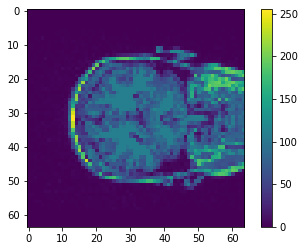

In [ ]:

import numpy as np
import nibabel as nib
import itertools
import os


def resize_data(data):
    initial_size_x = data.shape[0]
    initial_size_y = data.shape[1]
    initial_size_z = data.shape[2]

    new_size_x = 64
    new_size_y = 64
    new_size_z = 64

    delta_x = initial_size_x / new_size_x
    delta_y = initial_size_y / new_size_y
    delta_z = initial_size_z / new_size_z

    new_data = np.zeros((new_size_x, new_size_y, new_size_z))

    for x, y, z in itertools.product(range(new_size_x),
                                     range(new_size_y),
                                     range(new_size_z)):
        new_data[x][y][z] = data[int(x * delta_x)][int(y * delta_y)][int(z * delta_z)]

    return new_data


def PreProcess(InputImages):
    
    #output=np.zeros(InputImages.shape,dtype=np.float)
    InputImages=InputImages.astype(np.float)
    for i in range(InputImages.shape[0]):
        try:
            if np.max(InputImages[i,:,:,:,:])==0:
                print(np.max(InputImages[i,:,:,:,:]))
                #plt.imshow(InputImages[i,:,:,:,:])
                
            InputImages[i,:,:,:,:]=InputImages[i,:,:,:,:]/np.max(InputImages[i,:,:,:,:])
#            output[i,:,:,:] = (output[i,:,:,:]* 2)-1
        except:
            InputImages[i,:,:,:]=InputImages[i,:,:,:]/np.max(InputImages[i,:,:,:])
#            output[i,:,:] = (output[i,:,:]* 2) -1
            
    return InputImages

Images=np.zeros((len(ImageFileNames),64, 64, 64, 1),dtype=np.uint8)    
LandmarkLocations=np.zeros((len(ImageFileNames),3,21),dtype=np.uint8)
#Images=np.zeros((150,64, 64, 64, 1),dtype=np.uint8)    
#LandmarkLocations=np.zeros((150,3,21),dtype=np.uint8)


#Images=np.zeros((1,64, 64, 64, 1),dtype=np.uint8)    
#LandmarkLocations=np.zeros((1,3,21),dtype=np.uint8)
## Loading all .nii files and landmark from .txt files
from numpy import zeros, newaxis

for i in tqdm(range(len(ImageFileNames))):
    img = nib.load(path_img+'/'+ImageFileNames[i])
    #downsampled_nii = resample_img(img, target_affine=np.eye(3)*256/63 , interpolation='nearest')
    img = np.array(img.dataobj)
    img = resize_data(img)
    #img=(img/np.max(img))
    img = img[:, :, :,newaxis]
    #print (img.dtype)
    Images[i,:,:,:,:]=img 
    #for j in range(20):
      #Images[i+len(ImageFileNames)*j,:,:,:,:]=img 
    FileName=ImageFileNames[i]
    FileName=FileName[:-4]
    
    df = pd.read_csv(path_mark+'/'+FileName+'.txt', header=None)
    landmark_x = df.iloc[:,0].values
    landmark_y = df.iloc[:,1].values
    landmark_z = df.iloc[:,2].values
    LandmarkLocations[i,0,:] = landmark_x//4
    LandmarkLocations[i,1,:] = landmark_y//4
    LandmarkLocations[i,2,:] = landmark_z//4
    #for k in range(20):
     # LandmarkLocations[i+len(ImageFileNames)*j,0,:] = landmark_x//4
      #LandmarkLocations[i+len(ImageFileNames)*j,1,:] = landmark_y//4
      #LandmarkLocations[i+len(ImageFileNames)*j,2,:] = landmark_z//4
## ploating a random image 


import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(Images[1,:,:,24,0])
plt.colorbar()
plt.plot()

X_train = PreProcess(Images)
X_train.shape

Num_landmarks = 5   # given as 5 because of the memory contraints
## creating the heatmaps for traing from the given landmarks
Images_HeatMaps=np.zeros((X_train.shape[0],X_train.shape[1],X_train.shape[2],X_train.shape[3],Num_landmarks),dtype=np.float)

Image_heatmap=np.zeros((64, 64, 64),dtype=np.float)



In [ ]:

for i in tqdm(range(X_train.shape[0])):
    for k in range(Num_landmarks):
      
#        h=np.argwhere(Images_seg[i,:,:]==2*Ind_impo_landmarks_matlab[k])    
        lms_1=LandmarkLocations[i,0,k]
        lms_2=LandmarkLocations[i,1,k]
        lms_3=LandmarkLocations[i,2,k]
        #print(lms_1,lms_2,lms_3)
        Image_heatmap[:,:,:]=0
        Image_heatmap[lms_1,lms_2,lms_3]=1
        Image_heatmap=gaussian_filter(Image_heatmap, sigma=2)
        ## Here we can change the value multipied to the heatmap from 100 and see if we get better results
        Image_heatmap=(Image_heatmap*100)
        Images_HeatMaps[i,:,:,:,k]=Image_heatmap

Y_train_heatmap = Images_HeatMaps

Y_train_heatmap.shape

100%|██████████| 103/103 [00:06<00:00, 16.42it/s]


(103, 64, 64, 64, 5)

In [ ]:


x_data = X_train#np.vstack([x_train,x_val])
y_data = Y_train_heatmap#np.vstack([y_train,y_val])



del X_train
del Y_train_heatmap

import gc

gc.collect()


4643

In [ ]:
x_test1 = X_train#np.vstack([x_train,x_val])
y_test1 = Y_train_heatmap#

NameError: ignored

In [ ]:
## returns expected keypoints
def spatial_softArgmax3d(filters, temperature = 1.0):
    
    shape = tf.shape(filters)
    #print("Shape : {}".format(shape))
    length , height, width, num_channels = shape[1], shape[2], shape[3] ,shape[4]
    
    posx, posy, posz = tf.meshgrid(tf.range(length),tf.range(height), tf.range(width), indexing='ij')
    #print("posx : {},posy : {},posz : {}".format(posx,posy,posz))
    
    posx = tf.reshape(posx, [height * width * length])
    posy = tf.reshape(posy, [height * width * length])
    posz = tf.reshape(posz, [height * width * length])
    posx = tf.cast(posx,tf.float32)
    posy = tf.cast(posy,tf.float32)
    posz = tf.cast(posz,tf.float32)

    # The below transformation is very inmportant to get the expected results 
    filters = tf.reshape(tf.transpose(filters, [0, 4, 1, 2 ,3]), [num_channels, height * width * length])
    
    softmax_attention = tf.nn.softmax(filters/0.001)
    #print(softmax_attention)
    
    expected_x = tf.reduce_sum(posx * softmax_attention, 1, keepdims = True)
    expected_y = tf.reduce_sum(posy * softmax_attention, 1, keepdims = True)
    expected_z = tf.reduce_sum(posz * softmax_attention, 1, keepdims = True)
    
    expected_xyz = tf.concat([expected_x, expected_y, expected_z], axis = 1)
    
    feature_keypoints = tf.reshape(expected_xyz, [-1, num_channels * 3])

    return expected_xyz
# this loss function gives a measure of how close is y_true heatmap is from y_pred heatmap 
# taking all the points in the gaussian and not just the keypoints
# not a final version still some modification is requried
def Maskedloss(y_true,y_pred):
  y_true1 = tf.reshape(tf.transpose(y_true, [0, 4, 1, 2 ,3]), [5, 64 * 64 * 64])
  y_pred1 = tf.reshape(tf.transpose(y_pred, [0, 4, 1, 2 ,3]), [5, 64 * 64 * 64])
  A = K.abs(y_pred1-y_true1)
  A = tf.math.multiply(y_true1,A)
  A = tf.reduce_sum(A,1,keepdims = True)
  return A
## its not in a usable form need to do some transformation and reshaping on y_true and y_pred

def dice_loss(y_true, y_pred):
  numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=(1,2,3))
  denominator = tf.reduce_sum(y_true + y_pred, axis=(1,2,3))

  return 1 - numerator / denominator
## its not in a usable form need to do some transformation and reshaping on y_true and y_pred
#def tversky_loss(beta):
def loss(y_true, y_pred, beta = 0.5):
  numerator = tf.reduce_sum(y_true * y_pred, axis=-1)
  denominator = y_true * y_pred + beta * (1 - y_true) * y_pred + (1 - beta) * y_true * (1 - y_pred)

  return 1 - (numerator + 1) / (tf.reduce_sum(denominator, axis=-1) + 1)

  return loss

In [ ]:
%load_ext tensorboard
from tensorflow.compat.v1.keras import backend as K
from glob import glob

from tensorflow.keras import applications
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.models import Model
import datetime
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import pickle
import tensorflow.keras
from tensorflow.keras import regularizers
from scipy import io
import argparse
import tensorflow as tf
from keras import initializers
## defining the loss functions using the help of the functions defined above
def custom_loss_reg_1 (y_true, y_pred):
    #A = tensorflow.keras.losses.mean_squared_error(y_true, y_pred)
    #B = tensorflow.keras.losses.mean_absolute_error(y_true, y_pred)
    
    A = spatial_softArgmax3d(y_pred)
    C = spatial_softArgmax3d(y_true)
    D = K.mean(K.sqrt(K.sum(K.square(C - A), axis=1)))
    #D = tensorflow.keras.losses.mean_absolute_error(C, A)
    #D = tensorflow.keras.losses.mean_squared_error(C, A)
    return(D)

def custom_loss_reg_0 (y_true, y_pred):
  #A = tensorflow.keras.losses.mean_squared_error(y_true, y_pred)
  B = tensorflow.keras.losses.mean_absolute_error(y_true, y_pred)
  return (B)

# not completed 
def custom_loss_reg_3 (y_true, y_pred, w = 0.2):
    #A = tensorflow.keras.losses.mean_squared_error(y_true, y_pred)
    #B = tensorflow.keras.losses.mean_absolute_error(y_true, y_pred)
    
    
    A = Maskedloss(y_true, y_pred)
    
    return(A)


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:

!rm -rf ./logs/ 


In [ ]:

NAME = "model1"

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs/{}".format(NAME))

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
batch_size=1

ngf=32
kernelSize_1=(3,3,3)
InputLayer=tensorflow.keras.layers.Input(shape=(64, 64, 64, 1))
x_1=tensorflow.keras.layers.Conv3D(ngf, kernel_size=kernelSize_1, dilation_rate=(1, 1, 1),kernel_initializer='he_normal', bias_initializer=initializers.Constant(0.1), activation='relu',padding='same',)(InputLayer)
x_1=tensorflow.keras.layers.Conv3D(2*ngf, kernel_size=kernelSize_1, dilation_rate=(1, 1, 1),kernel_initializer='he_normal', bias_initializer=initializers.Constant(0.1), activation='relu',padding='same',)(x_1)

        
kernelSize_2=(3,3,3)
x_2=tensorflow.keras.layers.Conv3D(ngf, kernel_size=kernelSize_2, dilation_rate=(2, 2, 2),kernel_initializer='he_normal', bias_initializer=initializers.Constant(0.1), activation='relu',padding='same',)(InputLayer)
x_2=tensorflow.keras.layers.Conv3D(2*ngf, kernel_size=kernelSize_2,kernel_initializer='he_normal', bias_initializer=initializers.Constant(0.1), dilation_rate=(2, 2, 2), activation='relu',padding='same',)(x_2)

        
        
kernelSize_3=(3,3,3)
x_3=tensorflow.keras.layers.Conv3D(ngf, kernel_size=kernelSize_3, dilation_rate=(3, 3, 3),kernel_initializer='he_normal', bias_initializer=initializers.Constant(0.1), activation='relu',padding='same',)(InputLayer)
x_3=tensorflow.keras.layers.Conv3D(2*ngf, kernel_size=kernelSize_3,kernel_initializer='he_normal', bias_initializer=initializers.Constant(0.1), dilation_rate=(3, 3, 3), activation='relu',padding='same',)(x_3)

        
kernelSize_4=(3,3,3)
x_4=tensorflow.keras.layers.Conv3D(ngf, kernel_size=kernelSize_4, dilation_rate=(4, 4, 4),kernel_initializer='he_normal', bias_initializer=initializers.Constant(0.1), activation='relu',padding='same',)(InputLayer)
x_4=tensorflow.keras.layers.Conv3D(2*ngf, kernel_size=kernelSize_4, dilation_rate=(4, 4, 4),kernel_initializer='he_normal', bias_initializer=initializers.Constant(0.1), activation='relu',padding='same',)(x_4)

        
kernelSize_5=(3,3,3)
x_5=tensorflow.keras.layers.Conv3D(ngf, kernel_size=kernelSize_5, dilation_rate=(5, 5, 5),kernel_initializer='he_normal', bias_initializer=initializers.Constant(0.1), activation='relu',padding='same',)(InputLayer)
x_5=tensorflow.keras.layers.Conv3D(2*ngf, kernel_size=kernelSize_5, dilation_rate=(5, 5, 5),kernel_initializer='he_normal', bias_initializer=initializers.Constant(0.1), activation='relu',padding='same',)(x_5)



#x_c = x_1        
x_c=tensorflow.keras.layers.concatenate([x_1,x_2,x_3,x_4,x_5],axis=-1)
x_c=tensorflow.keras.layers.Conv3D(8*ngf, kernel_size=(3,3,3), dilation_rate=(1, 1, 1),kernel_initializer='he_normal', bias_initializer=initializers.Constant(0.1), activation='relu',padding='same',)(x_c)
x_c=tensorflow.keras.layers.Conv3D(4*ngf, kernel_size=(2,2,2), dilation_rate=(1, 1, 1),kernel_initializer='he_normal', bias_initializer=initializers.Constant(0.1), activation='relu',padding='same',)(x_c)
x_c=tensorflow.keras.layers.Conv3D(2*ngf, kernel_size=(1,1,1), dilation_rate=(1, 1, 1),kernel_initializer='he_normal', bias_initializer=initializers.Constant(0.1), activation='relu',padding='same',)(x_c)               
FinalHeatMaps=tensorflow.keras.layers.Conv3D(Num_landmarks, kernel_size=(1,1,1), dilation_rate=(1, 1,1),kernel_initializer='he_normal', bias_initializer=initializers.Constant(0.1), activation='tanh',padding='same',)(x_c)

        
model_final=Model(inputs=InputLayer,outputs=FinalHeatMaps)
model_final.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 64,  0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 64, 64, 64, 3 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv3d_2 (Conv3D)               (None, 64, 64, 64, 3 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv3d_4 (Conv3D)               (None, 64, 64, 64, 3 896         input_1[0][0]                    
_______________________________________________________________________________________

In [ ]:
def create_model(path):
    
  NAME = "model1"

  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs/{}".format(NAME))

  from tensorflow.keras.callbacks import ModelCheckpoint
  from tensorflow.keras.callbacks import EarlyStopping
  batch_size=1

  ngf=32
  kernelSize_1=(3,3,3)
  InputLayer=tensorflow.keras.layers.Input(shape=(64, 64, 64, 1))
  x_1=tensorflow.keras.layers.Conv3D(ngf, kernel_size=kernelSize_1, dilation_rate=(1, 1, 1),kernel_initializer='he_normal', bias_initializer=initializers.Constant(0.1), activation='relu',padding='same',)(InputLayer)
  x_1=tensorflow.keras.layers.Conv3D(2*ngf, kernel_size=kernelSize_1, dilation_rate=(1, 1, 1),kernel_initializer='he_normal', bias_initializer=initializers.Constant(0.1), activation='relu',padding='same',)(x_1)

          
  kernelSize_2=(3,3,3)
  x_2=tensorflow.keras.layers.Conv3D(ngf, kernel_size=kernelSize_2, dilation_rate=(2, 2, 2),kernel_initializer='he_normal', bias_initializer=initializers.Constant(0.1), activation='relu',padding='same',)(InputLayer)
  x_2=tensorflow.keras.layers.Conv3D(2*ngf, kernel_size=kernelSize_2,kernel_initializer='he_normal', bias_initializer=initializers.Constant(0.1), dilation_rate=(2, 2, 2), activation='relu',padding='same',)(x_2)

          
          
  kernelSize_3=(3,3,3)
  x_3=tensorflow.keras.layers.Conv3D(ngf, kernel_size=kernelSize_3, dilation_rate=(3, 3, 3),kernel_initializer='he_normal', bias_initializer=initializers.Constant(0.1), activation='relu',padding='same',)(InputLayer)
  x_3=tensorflow.keras.layers.Conv3D(2*ngf, kernel_size=kernelSize_3,kernel_initializer='he_normal', bias_initializer=initializers.Constant(0.1), dilation_rate=(3, 3, 3), activation='relu',padding='same',)(x_3)

          
  kernelSize_4=(3,3,3)
  x_4=tensorflow.keras.layers.Conv3D(ngf, kernel_size=kernelSize_4, dilation_rate=(4, 4, 4),kernel_initializer='he_normal', bias_initializer=initializers.Constant(0.1), activation='relu',padding='same',)(InputLayer)
  x_4=tensorflow.keras.layers.Conv3D(2*ngf, kernel_size=kernelSize_4, dilation_rate=(4, 4, 4),kernel_initializer='he_normal', bias_initializer=initializers.Constant(0.1), activation='relu',padding='same',)(x_4)

          
  kernelSize_5=(3,3,3)
  x_5=tensorflow.keras.layers.Conv3D(ngf, kernel_size=kernelSize_5, dilation_rate=(5, 5, 5),kernel_initializer='he_normal', bias_initializer=initializers.Constant(0.1), activation='relu',padding='same',)(InputLayer)
  x_5=tensorflow.keras.layers.Conv3D(2*ngf, kernel_size=kernelSize_5, dilation_rate=(5, 5, 5),kernel_initializer='he_normal', bias_initializer=initializers.Constant(0.1), activation='relu',padding='same',)(x_5)



  #x_c = x_1        
  x_c=tensorflow.keras.layers.concatenate([x_1,x_2,x_3,x_4,x_5],axis=-1)
  x_c=tensorflow.keras.layers.Conv3D(8*ngf, kernel_size=(3,3,3), dilation_rate=(1, 1, 1),kernel_initializer='he_normal', bias_initializer=initializers.Constant(0.1), activation='relu',padding='same',)(x_c)
  x_c=tensorflow.keras.layers.Conv3D(4*ngf, kernel_size=(2,2,2), dilation_rate=(1, 1, 1),kernel_initializer='he_normal', bias_initializer=initializers.Constant(0.1), activation='relu',padding='same',)(x_c)
  x_c=tensorflow.keras.layers.Conv3D(2*ngf, kernel_size=(1,1,1), dilation_rate=(1, 1, 1),kernel_initializer='he_normal', bias_initializer=initializers.Constant(0.1), activation='relu',padding='same',)(x_c)               
  FinalHeatMaps=tensorflow.keras.layers.Conv3D(Num_landmarks, kernel_size=(1,1,1), dilation_rate=(1, 1,1),kernel_initializer='he_normal', bias_initializer=initializers.Constant(0.1), activation='tanh',padding='same',)(x_c)

          
  model_final=Model(inputs=InputLayer,outputs=FinalHeatMaps)
  #model_final.summary()
  UsedOptimizer = optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)
  #UsedOptimizer=tensorflow.keras.optimizers.RMSprop(lr=0.0001, rho=0.9, epsilon=None, decay=0.0)


  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20,restore_best_weights=True)
  #checkpoint = ModelCheckpoint("best_model.hdf5", monitor='loss', verbose=1,
      #save_best_only=False, mode='auto', period=1)


  def MAE(y_true, y_pred):
      A = spatial_softArgmax3d(y_pred)*3.0
      C = spatial_softArgmax3d(y_true)*3.0
      return K.mean(K.abs(C-A))

  def MEE(y_true, y_pred):
      print(y_true.shape)
      A = spatial_softArgmax3d(y_pred)*3.0
      C = spatial_softArgmax3d(y_true)*3.0
      #print("A : {}".format((K.sqrt(K.sum(K.square(A - C), axis=1)))))
      return K.sqrt(K.sum(K.square(A - C), axis=1))

  def RMSE(y_true, y_pred):
      A = spatial_softArgmax3d(y_pred)
      C = spatial_softArgmax3d(y_true)
      return K.sqrt(K.mean(K.square(A - C), axis=1))

      
  model_final.compile(loss=custom_loss_reg_1, optimizer=UsedOptimizer,metrics=[MAE,MEE])    


  #checkpoint_path = "/content/drive/My Drive/Database/Model_training_5/Original/cp.ckpt"
  #checkpoint_dir = os.path.dirname(checkpoint_path)

  filepath="/content/drive/My Drive/Database/Model_training_5_new/DA1/epochs:{epoch:03d}-val_loss:{val_loss:.3f}.hdf5"
  checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min',save_freq='epoch')

  #cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
  #                                   save_weights_only=True,
  #                                   verbose=1)
  #filepath = '/content/drive/My Drive/Database/Model_training_5/DA1'
  #checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='max',save_freq='epoch')
  #callbacks_list = [checkpoint]
  model_final.load_weights(path)
  return model_final

In [ ]:
from keras.callbacks import CSVLogger


UsedOptimizer = optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)


es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20,restore_best_weights=True)

csv_logger = CSVLogger("/content/drive/My Drive/Dataset/20/model_history_log.csv", append=True)

def MAE(y_true, y_pred):
    A = spatial_softArgmax3d(y_pred)
    C = spatial_softArgmax3d(y_true)
    return K.mean(K.abs(C-A))*3.0

def MEE(y_true, y_pred):
    print(y_true.shape)
    A = spatial_softArgmax3d(y_pred)
    C = spatial_softArgmax3d(y_true)
    return K.mean(K.sqrt(K.sum(K.square(A - C), axis=1)))*3.0

def RMSE(y_true, y_pred):
    A = spatial_softArgmax3d(y_pred)
    C = spatial_softArgmax3d(y_true)
    return K.mean(K.sqrt(K.mean(K.square(A - C), axis=1)))*3.0

    
model_final.compile(loss=custom_loss_reg_3, optimizer=UsedOptimizer,metrics=[MAE,MEE,RMSE])    


filepath="/content/drive/My Drive/Dataset/20/epochs:{epoch:03d}-val_loss:{val_loss:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min',save_freq='epoch')


In [ ]:
model_final.load_weights('/content/drive/My Drive/Testing/Type2/epochs:124-val_loss:1.267.hdf5')

In [ ]:

x_test1 = np.load('/content/drive/My Drive/Database/stored_numpy/x_test1.npy')
y_test1 = np.load('/content/drive/My Drive/Database/stored_numpy/y_test1.npy')

x_test2 = np.load('/content/drive/My Drive/Database/stored_numpy/x_test2.npy')
y_test2 = np.load('/content/drive/My Drive/Database/stored_numpy/y_test2.npy')


In [ ]:
np.save("/content/drive/My Drive/Database/stored_numpy/x_test1.npy",x_test1)
np.save("/content/drive/My Drive/Database/stored_numpy/y_test1.npy",y_test1)
np.save("/content/drive/My Drive/Database/stored_numpy/x_test2.npy",x_test2)
np.save("/content/drive/My Drive/Database/stored_numpy/y_test2.npy",y_test2)
np.save("/content/drive/My Drive/Database/stored_numpy/x_test3.npy",x_test3)
np.save("/content/drive/My Drive/Database/stored_numpy/y_test3.npy",y_test3)

In [ ]:
from sklearn.model_selection import KFold
kfold = KFold(3, True, 1)
t = []
v = []
for train, val in kfold.split(x_data):
  t.append(train)
  v.append(val)

In [ ]:
x_train = x_data[0:70]
y_train = y_data[0:70]
x_val = x_data[70:103]
y_val = y_data[70:103]

History=model_final.fit(x_train, y_train,
            batch_size=batch_size, shuffle=True, validation_data=(x_val,y_val),
            epochs=500,#initial_epoch=34,
            verbose=1,callbacks=[es,csv_logger,checkpoint])

Epoch 1/500
(1, 64, 64, 64, 5)
(1, 64, 64, 64, 5)
70/70 [==============================] - ETA: 0s - loss: 43.5126 - MAE: 25.0232 - MEE: 50.0763 - RMSE: 28.9116(1, 64, 64, 64, 5)

Epoch 00001: val_loss improved from inf to 36.59632, saving model to /content/drive/My Drive/Dataset/20/epochs:001-val_loss:36.596.hdf5
70/70 [==============================] - 67s 960ms/step - loss: 43.5126 - MAE: 25.0232 - MEE: 50.0763 - RMSE: 28.9116 - val_loss: 36.5963 - val_MAE: 26.9011 - val_MEE: 55.0099 - val_RMSE: 31.7600
Epoch 2/500
70/70 [==============================] - ETA: 0s - loss: 36.1349 - MAE: 27.9638 - MEE: 55.7145 - RMSE: 32.1668
Epoch 00002: val_loss improved from 36.59632 to 35.13052, saving model to /content/drive/My Drive/Dataset/20/epochs:002-val_loss:35.131.hdf5
70/70 [==============================] - 66s 945ms/step - loss: 36.1349 - MAE: 27.9638 - MEE: 55.7145 - RMSE: 32.1668 - val_loss: 35.1305 - val_MAE: 24.7939 - val_MEE: 49.4484 - val_RMSE: 28.5491
Epoch 3/500
70/70 [=========

In [ ]:
from sklearn.model_selection import KFold

kfold = KFold(5, True, 1)
t = []
v = []

for train, val in kfold.split(x_data):
  t.append(train)
  v.append(train)

i = 0
x_train = x_data[t[i]]
y_train = y_data[t[i]]
x_val = x_data[v[i]]
y_val = y_data[v[i]]

History=model_final.fit(x_train, y_train,
            batch_size=batch_size, shuffle=True, validation_data=(x_val,y_val),
            epochs=500,
            verbose=1,callbacks=[tensorboard_callback,es,checkpoint])



Train on 164 samples, validate on 164 samples
Epoch 1/500
105/164 [==================>...........] - ETA: 55s - loss: 6.4878 - MAE: 5.6448 - MEE: 11.4137

In [ ]:

import pandas as pd

hist_df = pd.DataFrame(History.history) 
hist_csv_file = '/content/drive/My Drive/Database/Model_training_5/DA1/history4.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)


# **Test For One Model**

In [ ]:
print(model_final.evaluate(x_test1, y_test1, batch_size=1))
print(model_final.evaluate(x_test2, y_test2, batch_size=1))
#print(model_final.evaluate(x_test3, y_test3, batch_size=1))

32/32 [==============================] - 7s 221ms/step - loss: 183853360.0000 - MAE: 1.4823 - MEE: 3.4725
[183853360.0, 1.482269048690796, 3.4725425243377686]
31/31 [==============================] - 7s 221ms/step - loss: 183852560.0000 - MAE: 1.3019 - MEE: 3.0135
[183852560.0, 1.3018829822540283, 3.0134811401367188]


In [ ]:
print(model_final.evaluate(x_test1, y_test1, batch_size=1))

(1, 64, 64, 64, 5)
(1, 64, 64, 64, 5)
32/32 [==============================] - 7s 221ms/step - loss: 8.2793 - MAE: 1.4823 - MEE: 3.4725
[8.279302597045898, 1.482269048690796, 3.4725425243377686]


In [ ]:
x_test = np.vstack([x_test1,x_test2])
y_test = np.vstack([y_test1,y_test2])
print(model_final.evaluate(x_test, y_test, batch_size=1))

63/63 [==============================] - 14s 224ms/step - loss: 183852960.0000 - MAE: 1.3935 - MEE: 3.2467
[183852960.0, 1.393507480621338, 3.246654987335205]


In [ ]:

from sklearn.model_selection import KFold
kfold = KFold(3, True, 1)
t1 = []
t2 = []
for train, val in kfold.split(x_data):
  x_train = x_data[train]
  y_train = y_data[train]
  x_val = x_data[val]
  y_val = y_data[val]
  t1.append(model_final.evaluate(x_train, y_train, batch_size=1))
  t2.append(model_final.evaluate(x_val, y_val, batch_size=1))
  
print(np.mean(t1,axis=0))
print(np.mean(t2,axis=0))



34/34 [==============================] - 8s 221ms/step - loss: 1.2504 - MAE: 0.0000e+00 - MEE: 0.0000e+00
[3.32180854 0.43678574 1.028078  ]
[3.29245309 0.43054597 1.01339118]


In [ ]:
for i in range(103):
  pred_example_heatmaps = model_final.predict(x_data[i,:,:,:,:])
  a = tf.convert_to_tensor(pred_example_heatmaps, np.float32)
  a = tf.transpose(a, [3, 0, 1, 2 ,4])
  dd =  spatial_softArgmax3d(a)
  p = dd.numpy()
  m = y_data[i,:,:,:,:]
  m = m.reshape(1,64,64,64,5)
  b = tf.convert_to_tensor(m, np.float32)
  d =  spatial_softArgmax3d(b)
  print(np.abs(dd-d))

[[ 1.4612141 32.999992  26.7481   ]
 [ 5.528187   1.1607513 11.084013 ]
 [ 5.9114666 34.984673  11.013805 ]
 [ 5.000002  17.         5.       ]
 [ 4.0530815 19.53984   25.998386 ]]
[[ 6.1963577 34.        20.31709  ]
 [ 5.537409  24.313175   8.627855 ]
 [17.95472   19.8316    15.279732 ]
 [ 9.789936  16.155994   0.5016289]
 [ 1.3452454 11.943012   7.7771416]]
[[ 1.0856419 29.999985  31.615215 ]
 [19.        18.         1.       ]
 [12.999989  31.99998    7.994467 ]
 [ 5.        18.         8.       ]
 [ 2.3909988 19.560184  25.000027 ]]
[[11.9856415  32.         10.000774  ]
 [10.210382   24.141342    2.9988956 ]
 [ 7.92791    22.646618   31.841152  ]
 [ 4.57642    16.919998    6.7194443 ]
 [ 0.88809013 30.053688   26.000015  ]]
[[ 7.4889374 33.000008   4.006008 ]
 [17.997738  26.994831   7.731332 ]
 [12.994339  36.9998     6.999901 ]
 [ 7.978533  18.002838   4.9984207]
 [ 1.0352936 18.004547  26.       ]]
[[ 0.8246937  32.000004   33.55707   ]
 [ 0.12731934  2.8196526  14.462566  ]
 [

KeyboardInterrupt: ignored

In [ ]:
def extract_keypoints(heatmap):
   
  val = np.argwhere(heatmap == np.max(heatmap))[0]
  return val

In [ ]:
pred_example_heatmaps = model_final.predict(x_test1[0,:,:,:,:])
pred_example_heatmaps[:,:,:,0,0].shape

(64, 64, 64)

In [ ]:
#new_heatmap = np.zeros(64*64*64*5).reshape(64,64,64,5)

for i in range(32):
  pred_example_heatmaps = model_final.predict(x_test1[i,:,:,:,:])
  
  #a = tf.convert_to_tensor(pred_example_heatmaps, np.float32)
  #a = tf.transpose(a, [3, 0, 1, 2 ,4])
  #dd =  spatial_softArgmax3d(a)
  #p = dd.numpy()
  new_landmarks = []
  for i in range(5):
    img = pred_example_heatmaps[:,:,:,0,i]
    img = img.reshape(64,64,64)
    val = extract_keypoints(img)
    new_landmarks.append(val)
  
  print(new_landmarks)
  m = y_test1[i,:,:,:,:]
  m = m.reshape(1,64,64,64,5)
  b = tf.convert_to_tensor(m, np.float32)
  d =  spatial_softArgmax3d(b)
  print(d)
  print(np.abs(new_landmarks-d))
  

In [ ]:
import math 

def calculate_MEE(model_final,x,y):
  s_train1 = 0
  for i in range(len(x)):
    pred_example_heatmaps = model_final.predict(x[i,:,:,:,:])
    a = tf.convert_to_tensor(pred_example_heatmaps, np.float32)
    a = tf.transpose(a, [3, 0, 1, 2 ,4])
    dd =  spatial_softArgmax3d(a)*4.0
    p = dd.numpy()
    m = y[i,:,:,:,:]
    m = m.reshape(1,64,64,64,5)
    b = tf.convert_to_tensor(m, np.float32)
    d =  spatial_softArgmax3d(b)*4.0
    s_train1 = s_train1 + np.mean(np.sqrt(np.sum(np.square(d-dd),axis=1)))
  return s_train1/(len(x))

def calculate_MEA(model_final,x,y):
  s_train2 = 0
  for i in range(len(x)):
    pred_example_heatmaps = model_final.predict(x[i,:,:,:,:])
    #a = tf.convert_to_tensor(pred_example_heatmaps, np.float32)
    #a = tf.transpose(a, [3, 0, 1, 2 ,4])
    #dd =  spatial_softArgmax3d(a)*4.0
    
    pred_example_heatmaps = model_final.predict(x_test1[i,:,:,:,:])
  
  #a = tf.convert_to_tensor(pred_example_heatmaps, np.float32)
    #a = tf.transpose(a, [3, 0, 1, 2 ,4])
    #dd =  spatial_softArgmax3d(a)
    #p = dd.numpy()
    d = []
    for i in range(5):
      img = pred_example_heatmaps[:,:,:,0,i]
      img = img.reshape(64,64,64)
      val = extract_keypoints(img)
      d.append(val)
    
    
    #p = dd.numpy()
    
    m = y[i,:,:,:,:]
    m = m.reshape(1,64,64,64,5)
    b = tf.convert_to_tensor(m, np.float32)
    d =  spatial_softArgmax3d(b)*4.0

    #d = d = landmarks(y_train[i,:,:,:,:])
    #print (np.sum((np.abs(a-b)))/5)

    s_train2 = s_train2 + np.mean((np.abs(d-dd)))
    #for j in range(5):
    #for j in range(5):
      # s_train1 = s_train1 + math.sqrt((d[j,0]-dd[j,0])**2+(d[j,1]-dd[j,1])**2+(d[j,2]-dd[j,2])**2)
  return s_train2/(len(x))


def calculate_Acc(x,y):
  count = 0
  for i in range(len(x)):
    pred_example_heatmaps = model_final.predict(x[i,:,:,:,:])
    a = tf.convert_to_tensor(pred_example_heatmaps, np.float32)
    a = tf.transpose(a, [3, 0, 1, 2 ,4])
    dd =  spatial_softArgmax3d(a)*4.0
    p = dd.numpy()
    
    m = y[i,:,:,:,:]
    m = m.reshape(1,64,64,64,5)
    b = tf.convert_to_tensor(m, np.float32)
    d =  spatial_softArgmax3d(b)*4.0
  
  for j in range(5):
    if math.sqrt((d[j,0]-dd[j,0])**2+(d[j,1]-dd[j,1])**2+(d[j,2]-dd[j,2])**2)<7:
      count = count+1

  return (count/(5*len(x)))*100

In [ ]:

from sklearn.model_selection import KFold
kfold = KFold(3, True, 1)
a1=0
a2=0
a3=0
a4=0

for train, val in kfold.split(x_data):
  x_train = x_data[train]
  y_train = y_data[train]
  x_val = x_data[val]
  y_val = y_data[val]
  a1 = a1 + calculate_MEA(model_final,x_train,y_train)
  a2 = a2 + calculate_MEE(model_final,x_train,y_train)
  a3 = a3 + calculate_MEA(model_final,x_val,y_val)
  a4 = a4 + calculate_MEE(model_final,x_val,y_val)
print(a1/3)
print(a2/3)
print(a3/3)
print(a4/3)  

15.663430285960748
32.78402265978951
15.663639022261284
32.78465998027094


In [ ]:
print(calculate_MEA(model_final,x_test1,y_test1))

78.99166870117188


In [ ]:
print(calculate_MEA(model_final,x_test1,y_test1))
print(calculate_MEE(model_final,x_test1,y_test1))

53.86334574222565
112.05819869041443


In [ ]:
print(calculate_MEA(model_final,x_train,y_train))
print(calculate_MEE(model_final,x_val,y_val))

56.374605040619336
112.81120995914235


In [ ]:
print(calculate_MEA(model_final,x_test1,y_test1))
print(calculate_MEE(model_final,x_test1,y_test1))
print(calculate_MEA(model_final,x_test2,y_test2))
print(calculate_MEE(model_final,x_test2,y_test2))
print(calculate_MEA(model_final,x_test3,y_test3))
print(calculate_MEE(model_final,x_test3,y_test3))

3.5441483557224274
7.848307982087135
3.455553639319635
7.57251359570411
3.6097556195169127
7.9682602612477424


In [ ]:
print(calculate_MEA(model_final,x_test1,y_test1))
print(calculate_MEE(model_final,x_test1,y_test1))
print(calculate_MEA(model_final,x_test2,y_test2))
print(calculate_MEE(model_final,x_test2,y_test2))
print(calculate_MEA(model_final,x_test3,y_test3))
print(calculate_MEE(model_final,x_test3,y_test3))

14.17659342288971
31.39323192834854
13.82221455727854
30.29005438281644
14.43902247806765
31.87304104499097


In [ ]:

from sklearn.model_selection import KFold
kfold = KFold(3, True, 1)

for train, val in kfold.split(x_data):
  x_train = x_data[train]
  y_train = y_data[train]
  x_val = x_data[val]
  y_val = y_data[val]
  print(calculate_MEA(model_final,x_train,y_train))
  print(calculate_MEE(model_final,x_train,y_train))
  print(calculate_MEA(model_final,x_val,y_val))
  print(calculate_MEE(model_final,x_val,y_val))
  break

In [ ]:
model1 = create_model('/content/drive/My Drive/Database/Model_training_new/DA1/Fold1/epochs:150-val_loss:0.254.hdf5')
model2 = create_model('/content/drive/My Drive/Database/Model_training_new/DA1/Fold2/epochs:099-val_loss:0.432.hdf5')
model3 = create_model('/content/drive/My Drive/Database/Model_training_new/DA1/Fold3/epochs:146-val_loss:0.248.hdf5')
#model4 = create_model('/content/drive/My Drive/Database/Model_training_5_new/DA1/Fold4/epochs:098-val_loss:0.613.hdf5')
#model5 = create_model('/content/drive/My Drive/Database/Model_training_5_new/DA1/Fold5/epochs:085-val_loss:0.697.hdf5')
model_list = [model1,model2,model3]#,model4,model5]

In [ ]:
def cal_test_m(model):
  metric = []
  metric.append(model.evaluate(x_test1, y_test1, batch_size=1))
  metric.append(model.evaluate(x_test2, y_test2, batch_size=1))
  return metric
sum1 = 0
sum2 = 0
sum3 = 0
sum4 = 0
for m in model_list:
  m1 = cal_test_m(m)
  print(m1)
  sum1 = sum1 + m1[0][1]
  sum2 = sum2 + m1[1][1]
  sum3 = sum3 + m1[0][2]
  sum4 = sum4 + m1[1][2]

print("test 1 MAE: {}".format(sum1/3))
print("test 2 MAE: {}".format(sum2/3))
print("test 1 MEE: {}".format(sum3/3))
print("test 2 MEE: {}".format(sum4/3))

(1, 64, 64, 64, 5)
(1, 64, 64, 64, 5)
31/31 [==============================] - 7s 220ms/step - loss: 4.0170 - MAE: 4.2131 - MEE: 9.2005
[[4.339524745941162, 4.265986442565918, 9.322407722473145], [4.016953468322754, 4.213137626647949, 9.20047664642334]]
(1, 64, 64, 64, 5)
(1, 64, 64, 64, 5)
31/31 [==============================] - 7s 220ms/step - loss: 3.9931 - MAE: 4.1898 - MEE: 9.0339
[[4.475107669830322, 4.288740158081055, 9.303190231323242], [3.99314284324646, 4.189825534820557, 9.03387451171875]]
(1, 64, 64, 64, 5)
(1, 64, 64, 64, 5)
31/31 [==============================] - 7s 220ms/step - loss: 3.9099 - MAE: 4.1978 - MEE: 9.0093
[[4.474514007568359, 4.307025909423828, 9.388280868530273], [3.9098994731903076, 4.1978230476379395, 9.00925350189209]]
test 1 MAE: 4.287250836690267
test 2 MAE: 4.200262069702148
test 1 MEE: 9.33795960744222
test 2 MEE: 9.081201553344727


In [ ]:
from sklearn.model_selection import KFold
#metric_train = []
#metric_test1 = []
#metric_test2 = []
#metric_val = []
#His = []
#model = []
kfold = KFold(3, True, 1)
t = []
v = []

for train, val in kfold.split(x_data):
  t.append(train)
  v.append(train)
def cal_train_m(model,i,t,v):
  metric = []
  x_train = x_data[t[i]]
  y_train = y_data[t[i]]
  x_val = x_data[v[i]]
  y_val = y_data[v[i]]
  metric.append(model.evaluate(x_train, y_train, batch_size=1))
  metric.append(model.evaluate(x_val, y_val, batch_size=1))
  return metric
  
sum1 = 0
sum2 = 0
sum3 = 0
sum4 = 0
count = 0
for m in model_list:
  #print(idx)
  m1 = cal_train_m(m,count,t,v)
  print(m1)
  sum1 = sum1 + m1[0][1]
  sum2 = sum2 + m1[1][1]
  sum3 = sum3 + m1[0][2]
  sum4 = sum4 + m1[1][2]
  count = count+1
print("train MAE: {}".format(sum1/3))
print("val MAE: {}".format(sum2/3))
print("train MEE: {}".format(sum3/3))
print("val MEE: {}".format(sum4/3))

137/137 [==============================] - 31s 226ms/step - loss: 0.2540 - MAE: 1.1163 - MEE: 2.2541
[[0.2540019750595093, 1.116297721862793, 2.2541403770446777], [0.2540019750595093, 1.116297721862793, 2.2541403770446777]]
137/137 [==============================] - 31s 226ms/step - loss: 0.4320 - MAE: 1.4977 - MEE: 3.0046
[[0.4319863021373749, 1.4976862668991089, 3.0046379566192627], [0.4319863021373749, 1.4976862668991089, 3.0046379566192627]]
138/138 [==============================] - 31s 226ms/step - loss: 0.2484 - MAE: 1.0864 - MEE: 2.1819
[[0.24836255609989166, 1.0863871574401855, 2.1818795204162598], [0.24836255609989166, 1.0863871574401855, 2.1818795204162598]]
train MAE: 1.233457048734029
val MAE: 1.233457048734029
train MEE: 2.4802192846934
val MEE: 2.4802192846934


In [ ]:

def cal_whole(model,x,y,i,t,v):
  m1=[]
  m2=[]
  m1.append(calculate_MEA(model,x_data[t[i]],y_data[t[i]]))
  m1.append(calculate_MEE(model,x_data[t[i]],y_data[t[i]]))
  m2.append(calculate_MEA(model,x_data[v[i]],y_data[v[i]]))
  m2.append(calculate_MEE(model,x_data[v[i]],y_data[v[i]]))
  return [m1,m2]

In [ ]:
from sklearn.model_selection import KFold
metric_train = []
metric_test1 = []
metric_test2 = []
metric_val = []


mea_train=0
mea_val=0
mee_train=0
mee_val=0
acc_train=0
acc_val=0

for i,m in enumerate(model_list):
  m1 = cal_whole(m,x_data,y_data,i,t,v)

  mea_val =mea_val + m1[1][0]
  mea_train =mea_train + m1[0][0]
  mee_val =mee_val + m1[1][1]
  mee_train =mee_train + m1[0][1]


print("Training : ")
print("MEA : {}".format(mea_train/3))
print("MEE : {}".format(mee_train/3))

print("Validation : ")
print("MEA : {}".format(mea_val/3))
print("MEE : {}".format(mee_val/3))

   
  

Training : 
MEA : 16.013557313472948
MEE : 34.21490520874247
Validation : 
MEA : 16.013557313472948
MEE : 34.21490520874247


In [ ]:
import math 

def calculate_MEE(model_final,x,y):
  s_train1 = 0
  for i in range(len(x)):
    pred_example_heatmaps = model_final.predict(x[i,:,:,:,:])
    a = tf.convert_to_tensor(pred_example_heatmaps, np.float32)
    a = tf.transpose(a, [3, 0, 1, 2 ,4])
    dd =  spatial_softArgmax3d(a)*4.0
    p = dd.numpy()
    m = y[i,:,:,:,:]
    m = m.reshape(1,64,64,64,5)
    b = tf.convert_to_tensor(m, np.float32)
    d =  spatial_softArgmax3d(b)*4.0
    s_train1 = s_train1 + np.mean(np.sqrt(np.sum(np.square(d-dd),axis=1)))
  return s_train1/(len(x))

def calculate_MEA(model_final,x,y):
  s_train2 = 0
  for i in range(len(x)):
    pred_example_heatmaps = model_final.predict(x[i,:,:,:,:])
    a = tf.convert_to_tensor(pred_example_heatmaps, np.float32)
    a = tf.transpose(a, [3, 0, 1, 2 ,4])
    dd =  spatial_softArgmax3d(a)*4.0
    p = dd.numpy()
    
    m = y[i,:,:,:,:]
    m = m.reshape(1,64,64,64,5)
    b = tf.convert_to_tensor(m, np.float32)
    d =  spatial_softArgmax3d(b)*4.0

    #d = d = landmarks(y_train[i,:,:,:,:])
    #print (np.sum((np.abs(a-b)))/5)

    s_train2 = s_train2 + np.mean((np.abs(d-dd)))
    #for j in range(5):
    #for j in range(5):
      # s_train1 = s_train1 + math.sqrt((d[j,0]-dd[j,0])**2+(d[j,1]-dd[j,1])**2+(d[j,2]-dd[j,2])**2)
  return s_train2/(len(x))


def calculate_Acc(x,y):
  count = 0
  for i in range(len(x)):
    pred_example_heatmaps = model_final.predict(x[i,:,:,:,:])
    a = tf.convert_to_tensor(pred_example_heatmaps, np.float32)
    a = tf.transpose(a, [3, 0, 1, 2 ,4])
    dd =  spatial_softArgmax3d(a)*4.0
    p = dd.numpy()
    
    m = y[i,:,:,:,:]
    m = m.reshape(1,64,64,64,5)
    b = tf.convert_to_tensor(m, np.float32)
    d =  spatial_softArgmax3d(b)*4.0
  
  for j in range(5):
    if math.sqrt((d[j,0]-dd[j,0])**2+(d[j,1]-dd[j,1])**2+(d[j,2]-dd[j,2])**2)<7:
      count = count+1

  return (count/(5*len(x)))*100

In [ ]:
def cal_test1(m):
  m1 = []
  m2 = []
  m1.append(calculate_MEA(m,x_test1,y_test1))
  m1.append(calculate_MEE(m,x_test1,y_test1))
  m2.append(calculate_MEA(m,x_test2,y_test2))
  m2.append(calculate_MEE(m,x_test2,y_test2))
  return [m1,m2]
  
    

In [ ]:
sum1 = 0
sum2 = 0
sum3 = 0
sum4 = 0
for m in model_list:
  m1 = cal_test1(m)
  print(m1)
  sum1 = sum1 + m1[0][0]
  sum2 = sum2 + m1[1][0]
  sum3 = sum3 + m1[0][1]
  sum4 = sum4 + m1[1][1]

print("test 1 MAE: {}".format(sum1/3))
print("test 2 MAE: {}".format(sum2/3))
print("test 1 MEE: {}".format(sum3/3))
print("test 2 MEE: {}".format(sum4/3))

[[13.232284277677536, 30.181258976459503], [13.033370387169622, 29.88572169888404]]
[[12.72087299823761, 29.117307603359222], [12.45360537498228, 28.622902285668157]]
[[15.047671854496002, 33.686164140701294], [15.121543853513655, 33.67488485766995]]
test 1 MAE: 13.666943043470383
test 2 MAE: 13.536173205221852
test 1 MEE: 30.99491024017334
test 2 MEE: 30.727836280740718


# **Model Ensemble**

In [ ]:
def ensemble_predictions(members, testX):
	# make predictions
	yhats = [model.predict(testX) for model in members]
	yhats = np.array(yhats)
	# sum across ensemble members
	result = np.mean(yhats, axis=0)
	# argmax across classes
	return result


In [ ]:
model11 = create_model('/content/drive/My Drive/Database/Model_training_5_new/DA1/Fold1/epochs:094-val_loss:0.637.hdf5')
model22 = create_model('/content/drive/My Drive/Database/Model_training_5_new/DA1/Fold1/epochs:089-val_loss:0.648.hdf5')
model33 = create_model('/content/drive/My Drive/Database/Model_training_5_new/DA1/Fold1/epochs:094-val_loss:0.637.hdf5')

model_list1 = [model11,model22,model33]

In [ ]:
model_list1 = model_list

In [ ]:
import math 

def calculate_MEE(models,x,y):
  s_train1 = 0
  for i in range(len(x)):
    pred_example_heatmaps = ensemble_predictions(models,x[i,:,:,:,:])
    a = tf.convert_to_tensor(pred_example_heatmaps, np.float32)
    a = tf.transpose(a, [3, 0, 1, 2 ,4])
    dd =  spatial_softArgmax3d(a)*4.0
    p = dd.numpy()
    m = y[i,:,:,:,:]
    m = m.reshape(1,64,64,64,5)
    b = tf.convert_to_tensor(m, np.float32)
    d =  spatial_softArgmax3d(b)*4.0
    s_train1 = s_train1 + np.mean(np.sqrt(np.sum(np.square(d-dd),axis=1)))
  return s_train1/(len(x))

def calculate_MEA(models,x,y):
  s_train2 = 0
  for i in range(len(x)):
    pred_example_heatmaps = ensemble_predictions(models,x[i,:,:,:,:])
    a = tf.convert_to_tensor(pred_example_heatmaps, np.float32)
    a = tf.transpose(a, [3, 0, 1, 2 ,4])
    dd =  spatial_softArgmax3d(a)*4.0
    p = dd.numpy()
    
    m = y[i,:,:,:,:]
    m = m.reshape(1,64,64,64,5)
    b = tf.convert_to_tensor(m, np.float32)
    d =  spatial_softArgmax3d(b)*4.0

    #d = d = landmarks(y_train[i,:,:,:,:])
    #print (np.sum((np.abs(a-b)))/5)

    s_train2 = s_train2 + np.mean((np.abs(d-dd)))
    #for j in range(5):
    #for j in range(5):
      # s_train1 = s_train1 + math.sqrt((d[j,0]-dd[j,0])**2+(d[j,1]-dd[j,1])**2+(d[j,2]-dd[j,2])**2)
  return s_train2/(len(x))


def calculate_Acc(x,y):
  count = 0
  for i in range(len(x)):
    pred_example_heatmaps = model_final.predict(x[i,:,:,:,:])
    a = tf.convert_to_tensor(pred_example_heatmaps, np.float32)
    a = tf.transpose(a, [3, 0, 1, 2 ,4])
    dd =  spatial_softArgmax3d(a)*4.0
    p = dd.numpy()
    
    m = y[i,:,:,:,:]
    m = m.reshape(1,64,64,64,5)
    b = tf.convert_to_tensor(m, np.float32)
    d =  spatial_softArgmax3d(b)*4.0
  
  for j in range(5):
    if math.sqrt((d[j,0]-dd[j,0])**2+(d[j,1]-dd[j,1])**2+(d[j,2]-dd[j,2])**2)<7:
      count = count+1

  return (count/(5*len(x)))*100

In [ ]:
print(calculate_MEA(model_list1,x_test1,y_test1))
print(calculate_MEE(model_list1,x_test1,y_test1))
print(calculate_MEA(model_list1,x_test2,y_test2))
print(calculate_MEE(model_list1,x_test2,y_test2))

13.247525125741959
29.971638202667236
13.076736542486376
29.661807767806515


In [ ]:
#from scipy.stats import gmean
def ensemble_predictions(members, testX):
	# make predictions
	yhats = [model.predict(testX) for model in members]
	yhats = np.array(yhats)
	# sum across ensemble members
	result = yhats[0]*0.5+yhats[1]*0.5+yhats[2]*0.5
	# argmax across classes
	return result


In [ ]:
print(calculate_MEA(model_list1,x_test1,y_test1))
print(calculate_MEE(model_list1,x_test1,y_test1))
print(calculate_MEA(model_list1,x_test2,y_test2))
print(calculate_MEE(model_list1,x_test2,y_test2))

12.907082319259644
29.095909237861633
12.78510533609698
28.80198072618054


In [ ]:

from sklearn.model_selection import KFold
#metric_train = []
#metric_test1 = []
#metric_test2 = []
#metric_val = []
#His = []
#model = []
kfold = KFold(5, True, 1)
t = []
v = []

for train, val in kfold.split(x_data):
  t.append(train)
  v.append(train)

for i in range(len(t)):  
  print("FOLD : {}".format(i+1))
  x_train = x_data[t[i]]
  y_train = y_data[t[i]]
  x_val = x_data[v[i]]
  y_val = y_data[v[i]]
  #print(y_train.shape)
  History=model_final.fit(x_train, y_train,
            batch_size=batch_size, shuffle=True, validation_data=(x_val,y_val),
            epochs=50,
            verbose=1,callbacks=[tensorboard_callback,es])#,checkpoint])
  #metric_train.append(model_final.evaluate(x_train, y_train, batch_size=1))
  #metric_val.append(model_final.evaluate(x_val, y_val, batch_size=1))
  #metric_test1.append(model_final.evaluate(x_test1, y_test1, batch_size=1))
  #metric_test2.append(model_final.evaluate(x_test2, y_test2, batch_size=1))
  #His.append(History)
  #model.append(model_final)

  del x_train
  del y_train
  del x_val
  del y_val
  K.clear_session()
  
  

In [ ]:
  del x_train
  del y_train
  del x_val
  del y_val
  K.clear_session()

In [ ]:
del x_train
del y_train
del x_val
del y_val
del x_test1
del x_test2
del y_test1
del y_test2

In [ ]:

from sklearn.model_selection import KFold
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
metric_train = []
metric_test = []
metric_val = []
His = []
model = []
kfold = KFold(5, True, 1)
saver=tf.train.Saver()
save_path='/content/drive/My Drive/Database/Model_training_5/DA1/new_train/'

saver.save(sess=session,save_path=save_path)

for train, val in kfold.split(x_data):
  x_train = x_data[train]
  y_train = y_data[train]
  x_val = x_data[val]
  y_val = y_data[val]
  #print(y_train.shape)
  History=model_final.fit(x_train, y_train,
            batch_size=batch_size, shuffle=True, validation_data=(x_val,y_val),
            epochs=100,
            verbose=1,callbacks=[tensorboard_callback,es,cp_callback])
  metric_train.append(model_final.evaluate(x_train, y_train, batch_size=1))
  metric_val.append(model_final.evaluate(x_val, y_val, batch_size=1))
  metric_test.append(model_final.evaluate(x_test, y_test, batch_size=1))
  His.append(History)
  model.append(model_final)

  del x_train
  del y_train
  del x_val
  del y_val
  
  
  

In [ ]:
model_final.evaluate(x_test1, y_test1, batch_size=1)

(1, 64, 64, 64, 5)
(1, 64, 64, 64, 5)
32/32 [==============================] - 7s 220ms/step - loss: 1.4372 - MAE: 4.3115 - MEE: 9.4317


[1.4371603727340698, 4.31148099899292, 9.431658744812012]

In [ ]:
model_final.evaluate(x_test2, y_test2, batch_size=1)

31/31 [==============================] - 7s 220ms/step - loss: 1.3918 - MAE: 4.1754 - MEE: 9.0313


[1.3917988538742065, 4.175395965576172, 9.031316757202148]

In [ ]:
from sklearn.model_selection import KFold
metric_train = []
metric_val = []
kfold = KFold(5, True, 1)

for train, val in kfold.split(x_data):
  x_train = x_data[train]
  y_train = y_data[train]
  x_val = x_data[val]
  y_val = y_data[val]
  metric_train.append(model_final.evaluate(x_train, y_train, batch_size=1))
  metric_val.append(model_final.evaluate(x_val, y_val, batch_size=1))
  break

42/42 [==============================] - 9s 221ms/step - loss: 0.7463 - MAE: 2.2389 - MEE: 4.6087


In [ ]:
metric_train
print(np.mean(metric_train,axis=0))
metric_val
print(np.mean(metric_val,axis=0))

[0.49332144 1.47996447 3.10374207]
[0.49346397 1.48039179 3.10457358]


In [ ]:
import math 

def calculate_MEE(x,y):
  s_train1 = 0
  for i in range(len(x)):
    pred_example_heatmaps = model_final.predict(x[i,:,:,:,:])
    a = tf.convert_to_tensor(pred_example_heatmaps, np.float32)
    a = tf.transpose(a, [3, 0, 1, 2 ,4])
    dd =  spatial_softArgmax3d(a)*4.0
    p = dd.numpy()
    m = y[i,:,:,:,:]
    m = m.reshape(1,64,64,64,5)
    b = tf.convert_to_tensor(m, np.float32)
    d =  spatial_softArgmax3d(b)*4.0
    s_train1 = s_train1 + np.mean(np.sqrt(np.sum(np.square(d-dd),axis=1)))
  return s_train1/(len(x))

def calculate_MEA(x,y):
  s_train2 = 0
  for i in range(len(x)):
    pred_example_heatmaps = model_final.predict(x[i,:,:,:,:])
    a = tf.convert_to_tensor(pred_example_heatmaps, np.float32)
    a = tf.transpose(a, [3, 0, 1, 2 ,4])
    dd =  spatial_softArgmax3d(a)*4.0
    p = dd.numpy()
    
    m = y[i,:,:,:,:]
    m = m.reshape(1,64,64,64,5)
    b = tf.convert_to_tensor(m, np.float32)
    d =  spatial_softArgmax3d(b)*4.0

    #d = d = landmarks(y_train[i,:,:,:,:])
    #print (np.sum((np.abs(a-b)))/5)

    s_train2 = s_train2 + np.mean((np.abs(d-dd)))
    #for j in range(5):
    #for j in range(5):
      # s_train1 = s_train1 + math.sqrt((d[j,0]-dd[j,0])**2+(d[j,1]-dd[j,1])**2+(d[j,2]-dd[j,2])**2)
  return s_train2/(len(x))


def calculate_Acc(x,y):
  count = 0
  for i in range(len(x)):
    pred_example_heatmaps = model_final.predict(x[i,:,:,:,:])
    a = tf.convert_to_tensor(pred_example_heatmaps, np.float32)
    a = tf.transpose(a, [3, 0, 1, 2 ,4])
    dd =  spatial_softArgmax3d(a)*4.0
    p = dd.numpy()
    
    m = y[i,:,:,:,:]
    m = m.reshape(1,64,64,64,5)
    b = tf.convert_to_tensor(m, np.float32)
    d =  spatial_softArgmax3d(b)*4.0
  
  for j in range(5):
    if math.sqrt((d[j,0]-dd[j,0])**2+(d[j,1]-dd[j,1])**2+(d[j,2]-dd[j,2])**2)<7:
      count = count+1

  return (count/(5*len(x)))*100

In [ ]:
from sklearn.model_selection import KFold
metric_train = []
metric_test1 = []
metric_test2 = []
metric_val = []
His = []
model = []
kfold = KFold(5, True, 1)
t = []
v = []

mea_train=0
mea_val=0
mee_train=0
mee_val=0
acc_train=0
acc_val=0
for train, val in kfold.split(x_data):
  mea_val =mea_val + calculate_MEA(x_data[val],y_data[val])
  mea_train =mea_train + calculate_MEA(x_data[train],y_data[train])
  mee_val =mee_val + calculate_MEE(x_data[val],y_data[val])
  mee_train =mee_train + calculate_MEE(x_data[train],y_data[train])
  acc_train = acc_train + calculate_Acc(x_data[train],y_data[train])
  acc_val = acc_val + calculate_Acc(x_data[val],y_data[val])


print("Training : ")
print("MEA : {}".format(mea_train/5))
print("MEE : {}".format(mee_train/5))
print("Accuracy : {}".format(acc_train/5))

print("Validation : ")
print("MEA : {}".format(mea_val/5))
print("MEE : {}".format(mee_val/5))
print("Accuracy : {}".format(acc_val/5))
   
  

Training : 
MEA : 17.083825490920525
MEE : 36.52613214716943
Accuracy : 0.0
Validation : 
MEA : 17.08915564352073
MEE : 36.53343373142468
Accuracy : 0.0


In [ ]:
print(calculate_MEE(x_test1,y_test1))

In [ ]:
print(calculate_MEA(x_test2,y_test2))

In [ ]:
print(calculate_MEE(x_test2,y_test2))

28.680103178947203


In [ ]:
print(calculate_MEA(x_test1,y_test1))

12.784093737602234


In [ ]:
mv *_6.txt '/content/drive/My Drive/Database/Aug_img_mrk/landmarks'

In [ ]:
for i in range(103):
  pred_example_heatmaps = model_final.predict(x_data[i,:,:,:,:])
  a = tf.convert_to_tensor(pred_example_heatmaps, np.float32)
  a = tf.transpose(a, [3, 0, 1, 2 ,4])
  dd =  spatial_softArgmax3d(a)*4.0
  p = dd.numpy()
  m = y_data[i,:,:,:,:]
  m = m.reshape(1,64,64,64,5)
  b = tf.convert_to_tensor(m, np.float32)
  d =  spatial_softArgmax3d(b)*4.0
  print(np.abs(dd-d))

[[  5.8448563 131.99997   106.9924   ]
 [ 22.112747    4.6430054  44.336052 ]
 [ 23.645866  139.93869    44.05522  ]
 [ 20.000008   68.         20.       ]
 [ 16.212326   78.15936   103.993546 ]]
[[ 24.78543   136.         81.26836  ]
 [ 22.149635   97.2527     34.51142  ]
 [ 71.81888    79.3264     61.118927 ]
 [ 39.159744   64.62398     2.0065155]
 [  5.3809814  47.77205    31.108566 ]]
[[  4.3425674 119.99994   126.46086  ]
 [ 76.         72.          4.       ]
 [ 51.999954  127.99992    31.977867 ]
 [ 20.         72.         32.       ]
 [  9.563995   78.24074   100.00011  ]]
[[ 47.942566  128.         40.003098 ]
 [ 40.84153    96.56537    11.995583 ]
 [ 31.71164    90.58647   127.36461  ]
 [ 18.30568    67.67999    26.877777 ]
 [  3.5523605 120.21475   104.00006  ]]
[[ 29.95575   132.00003    16.024033 ]
 [ 71.99095   107.979324   30.925327 ]
 [ 51.977356  147.9992     27.999603 ]
 [ 31.914131   72.01135    19.993683 ]
 [  4.1411743  72.01819   104.       ]]
[[  3.2987747  128.0

In [ ]:
for i in range(164):
  pred_example_heatmaps = model_final.predict(x_test1[i,:,:,:,:])
  a = tf.convert_to_tensor(pred_example_heatmaps, np.float32)
  a = tf.transpose(a, [3, 0, 1, 2 ,4])
  dd =  spatial_softArgmax3d(a)*4.0
  p = dd.numpy()
  m = y_test1[i,:,:,:,:]
  m = m.reshape(1,64,64,64,5)
  b = tf.convert_to_tensor(m, np.float32)
  d =  spatial_softArgmax3d(b)*4.0
  print(np.abs(dd-d))
  

[[ 21.873215  140.00003    92.430786 ]
 [ 12.361877  100.55911    40.70859  ]
 [ 57.67282    68.3313     86.011185 ]
 [ 75.79628     0.389122   51.906685 ]
 [  1.9129257   8.895813  103.9904   ]]
[[ 42.345     155.99997    53.347794 ]
 [ 75.97514     2.0164871  22.090141 ]
 [ 17.900085  163.74057    38.290237 ]
 [ 24.93354    65.70511    25.1474   ]
 [ 10.981003   47.461884  111.99269  ]]
[[ 47.850204  136.00002    67.98276  ]
 [ 44.142975   38.139465   18.827438 ]
 [ 39.810684   95.406586   57.90799  ]
 [ 62.675423    3.5908585  36.16912  ]
 [  4.0111084   3.4972382 107.997574 ]]
[[1.1218948e+01 1.3600000e+02 8.7567215e+00]
 [4.8812866e-02 1.1833954e-01 9.9978737e+01]
 [7.6176575e+01 9.0633743e+01 6.8380585e+01]
 [1.0391296e+01 5.6086426e+00 3.0389221e+01]
 [1.1998779e+01 6.4014145e+01 1.0400000e+02]]
[[ 31.979324 140.        93.7854  ]
 [ 44.932228 109.13699   37.795326]
 [ 39.023827 106.87688   56.453278]
 [ 23.971947  47.954575  15.987045]
 [ 19.076828  26.563354 100.000015]]
[[3.7

IndexError: ignored

In [ ]:
import math 

s_train1 = 0
for i in range(164):
  pred_example_heatmaps = model_final.predict(x_data[i,:,:,:,:])
  a = tf.convert_to_tensor(pred_example_heatmaps, np.float32)
  a = tf.transpose(a, [3, 0, 1, 2 ,4])
  dd =  spatial_softArgmax3d(a)*4.0
  p = dd.numpy()
  m = y_data[i,:,:,:,:]
  m = m.reshape(1,64,64,64,5)
  b = tf.convert_to_tensor(m, np.float32)
  d =  spatial_softArgmax3d(b)*4.0
  s_train1 = s_train1 + np.mean(np.sqrt(np.sum(np.square(d-dd),axis=1)))
  #for j in range(5):
   # s_train1 = s_train1 + math.sqrt((d[j,0]-dd[j,0])**2+(d[j,1]-dd[j,1])**2+(d[j,2]-dd[j,2])**2)


s_train2 = 0
for i in range(164):
  pred_example_heatmaps = model_final.predict(x_data[i,:,:,:,:])
  a = tf.convert_to_tensor(pred_example_heatmaps, np.float32)
  a = tf.transpose(a, [3, 0, 1, 2 ,4])
  dd =  spatial_softArgmax3d(a)*4.0
  p = dd.numpy()
  
  m = y_data[i,:,:,:,:]
  m = m.reshape(1,64,64,64,5)
  b = tf.convert_to_tensor(m, np.float32)
  d =  spatial_softArgmax3d(b)*4.0

  #d = d = landmarks(y_train[i,:,:,:,:])
  #print (np.sum((np.abs(a-b)))/5)

  s_train2 = s_train2 + np.mean((np.abs(d-dd)))
  #for j in range(5):
   # s_train2 = s_train2 + ((d[j,0]-dd[j,0])+np.abs(d[j,1]-dd[j,1])+np.abs(d[j,2]-dd[j,2]))



points = []
count = 0
for i in range(164):
  pred_example_heatmaps = model_final.predict(x_data[i,:,:,:,:])
  a = tf.convert_to_tensor(pred_example_heatmaps, np.float32)
  a = tf.transpose(a, [3, 0, 1, 2 ,4])
  dd =  spatial_softArgmax3d(a)*4.0
  p = dd.numpy()
  m = y_data[i,:,:,:,:]
  m = m.reshape(1,64,64,64,5)
  b = tf.convert_to_tensor(m, np.float32)
  d =  spatial_softArgmax3d(b)*4.0
  points.append(d)
  for j in range(5):
    if math.sqrt((d[j,0]-dd[j,0])**2+(d[j,1]-dd[j,1])**2+(d[j,2]-dd[j,2])**2)<7:
      count = count+1

print("Train MEE : {}".format(s_train1/(164)))
print("Train MAE : {}".format(s_train2/(164)))
print((count/(5*164))*100)

In [ ]:
import math 

s_val1 = 0
for i in range(164,206):
  pred_example_heatmaps = model_final.predict(x_data[i,:,:,:,:])
  a = tf.convert_to_tensor(pred_example_heatmaps, np.float32)
  a = tf.transpose(a, [3, 0, 1, 2 ,4])
  dd =  spatial_softArgmax3d(a)*4.0
  p = dd.numpy()
  m = y_data[i,:,:,:,:]
  m = m.reshape(1,64,64,64,5)
  b = tf.convert_to_tensor(m, np.float32)
  d =  spatial_softArgmax3d(b)*4.0
  s_val1 = s_val1 + np.mean(np.sqrt(np.sum(np.square(d-dd),axis=1)))
  #for j in range(5):
   # s_train1 = s_train1 + math.sqrt((d[j,0]-dd[j,0])**2+(d[j,1]-dd[j,1])**2+(d[j,2]-dd[j,2])**2)


s_val2 = 0
for i in range(164,206):
  pred_example_heatmaps = model_final.predict(x_data[i,:,:,:,:])
  a = tf.convert_to_tensor(pred_example_heatmaps, np.float32)
  a = tf.transpose(a, [3, 0, 1, 2 ,4])
  dd =  spatial_softArgmax3d(a)*4.0
  p = dd.numpy()
  
  m = y_data[i,:,:,:,:]
  m = m.reshape(1,64,64,64,5)
  b = tf.convert_to_tensor(m, np.float32)
  d =  spatial_softArgmax3d(b)*4.0

  #d = d = landmarks(y_train[i,:,:,:,:])
  #print (np.sum((np.abs(a-b)))/5)

  s_val2 = s_val2 + np.mean((np.abs(d-dd)))
  #for j in range(5):
   # s_train2 = s_train2 + ((d[j,0]-dd[j,0])+np.abs(d[j,1]-dd[j,1])+np.abs(d[j,2]-dd[j,2]))



points = []
count = 0
for i in range(164,206):
  pred_example_heatmaps = model_final.predict(x_data[i,:,:,:,:])
  a = tf.convert_to_tensor(pred_example_heatmaps, np.float32)
  a = tf.transpose(a, [3, 0, 1, 2 ,4])
  dd =  spatial_softArgmax3d(a)*4.0
  p = dd.numpy()
  m = y_data[i,:,:,:,:]
  m = m.reshape(1,64,64,64,5)
  b = tf.convert_to_tensor(m, np.float32)
  d =  spatial_softArgmax3d(b)*4.0
  points.append(d)
  for j in range(5):
    if math.sqrt((d[j,0]-dd[j,0])**2+(d[j,1]-dd[j,1])**2+(d[j,2]-dd[j,2])**2)<7:
      count = count+1

print("Train MEE : {}".format(s_train1/(42)))
print("Train MAE : {}".format(s_train2/(42)))
print((count/(5*42))*100)

In [ ]:
import math 

s_test1 = 0
for i in range(32):
  pred_example_heatmaps = model_final.predict(x_test[i,:,:,:,:])
  a = tf.convert_to_tensor(pred_example_heatmaps, np.float32)
  a = tf.transpose(a, [3, 0, 1, 2 ,4])
  dd =  spatial_softArgmax3d(a)*4.0
  p = dd.numpy()
  m = y_test[i,:,:,:,:]
  m = m.reshape(1,64,64,64,5)
  b = tf.convert_to_tensor(m, np.float32)
  d =  spatial_softArgmax3d(b)*4.0
  s_test1 = s_test1 + np.mean(np.sqrt(np.sum(np.square(d-dd),axis=1)))
  #for j in range(5):
   # s_train1 = s_train1 + math.sqrt((d[j,0]-dd[j,0])**2+(d[j,1]-dd[j,1])**2+(d[j,2]-dd[j,2])**2)


s_test2 = 0
for i in range(32):
  pred_example_heatmaps = model_final.predict(x_test[i,:,:,:,:])
  a = tf.convert_to_tensor(pred_example_heatmaps, np.float32)
  a = tf.transpose(a, [3, 0, 1, 2 ,4])
  dd =  spatial_softArgmax3d(a)*4.0
  p = dd.numpy()
  
  m = y_test[i,:,:,:,:]
  m = m.reshape(1,64,64,64,5)
  b = tf.convert_to_tensor(m, np.float32)
  d =  spatial_softArgmax3d(b)*4.0

  #d = d = landmarks(y_train[i,:,:,:,:])
  #print (np.sum((np.abs(a-b)))/5)

  s_test2 = s_test2 + np.mean((np.abs(d-dd)))
  #for j in range(5):
   # s_train2 = s_train2 + ((d[j,0]-dd[j,0])+np.abs(d[j,1]-dd[j,1])+np.abs(d[j,2]-dd[j,2]))



points = []
count = 0
for i in range(32):
  pred_example_heatmaps = model_final.predict(x_test[i,:,:,:,:])
  a = tf.convert_to_tensor(pred_example_heatmaps, np.float32)
  a = tf.transpose(a, [3, 0, 1, 2 ,4])
  dd =  spatial_softArgmax3d(a)*4.0
  p = dd.numpy()
  m = y_test[i,:,:,:,:]
  m = m.reshape(1,64,64,64,5)
  b = tf.convert_to_tensor(m, np.float32)
  d =  spatial_softArgmax3d(b)*4.0
  points.append(d)
  for j in range(5):
    if math.sqrt((d[j,0]-dd[j,0])**2+(d[j,1]-dd[j,1])**2+(d[j,2]-dd[j,2])**2)<7:
      count = count+1

print("Train MEE : {}".format(s_train1/(32)))
print("Train MAE : {}".format(s_train2/(32)))
print((count/(5*32))*100)

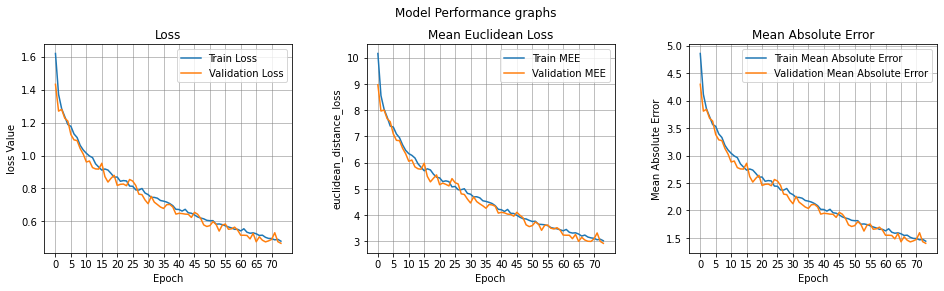

In [ ]:
%matplotlib inline
hist = History
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))
t = f.suptitle('Model Performance graphs', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)
epoch_list = hist.epoch

ax1.plot(epoch_list, hist.history['loss'], label='Train Loss')
ax1.plot(epoch_list, hist.history['val_loss'], label='Validation Loss')
ax1.set_xticks(np.arange(0, epoch_list[-1], 5))
ax1.set_ylabel('loss Value');ax1.set_xlabel('Epoch');ax1.set_title('Loss')
ax1.legend(loc="best");ax1.grid(color='gray', linestyle='-', linewidth=0.5)

ax2.plot(epoch_list, hist.history['MEE'], label='Train MEE')
ax2.plot(epoch_list, hist.history['val_MEE'], label='Validation MEE')
ax2.set_xticks(np.arange(0, epoch_list[-1], 5))
ax2.set_ylabel('euclidean_distance_loss');ax2.set_xlabel('Epoch');ax2.set_title('Mean Euclidean Loss')
ax2.legend(loc="best");ax2.grid(color='gray', linestyle='-', linewidth=0.5)

ax3.plot(epoch_list, hist.history['MAE'], label='Train Mean Absolute Error')
ax3.plot(epoch_list, hist.history['val_MAE'], label='Validation Mean Absolute Error')
ax3.set_xticks(np.arange(0, epoch_list[-1], 5))
ax3.set_ylabel('Mean Absolute Error');ax3.set_xlabel('Epoch');ax3.set_title('Mean Absolute Error')
ax3.legend(loc="best");ax3.grid(color='gray', linestyle='-', linewidth=0.5)

In [ ]:
%matplotlib inline
hist = His[1]
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))
t = f.suptitle('Model Performance graphs', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)
epoch_list = hist.epoch

ax1.plot(epoch_list, hist.history['loss'], label='Train Loss')
ax1.plot(epoch_list, hist.history['val_loss'], label='Validation Loss')
ax1.set_xticks(np.arange(0, epoch_list[-1], 5))
ax1.set_ylabel('loss Value');ax1.set_xlabel('Epoch');ax1.set_title('Loss')
ax1.legend(loc="best");ax1.grid(color='gray', linestyle='-', linewidth=0.5)

ax2.plot(epoch_list, hist.history['MEE'], label='Train MEE')
ax2.plot(epoch_list, hist.history['val_MEE'], label='Validation MEE')
ax2.set_xticks(np.arange(0, epoch_list[-1], 5))
ax2.set_ylabel('euclidean_distance_loss');ax2.set_xlabel('Epoch');ax2.set_title('Mean Euclidean Loss')
ax2.legend(loc="best");ax2.grid(color='gray', linestyle='-', linewidth=0.5)

ax3.plot(epoch_list, hist.history['MAE'], label='Train Mean Absolute Error')
ax3.plot(epoch_list, hist.history['val_MAE'], label='Validation Mean Absolute Error')
ax3.set_xticks(np.arange(0, epoch_list[-1], 5))
ax3.set_ylabel('Mean Absolute Error');ax3.set_xlabel('Epoch');ax3.set_title('Mean Absolute Error')
ax3.legend(loc="best");ax3.grid(color='gray', linestyle='-', linewidth=0.5)

In [ ]:
%matplotlib inline
hist = His[2]
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))
t = f.suptitle('Model Performance graphs', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)
epoch_list = hist.epoch

ax1.plot(epoch_list, hist.history['loss'], label='Train Loss')
ax1.plot(epoch_list, hist.history['val_loss'], label='Validation Loss')
ax1.set_xticks(np.arange(0, epoch_list[-1], 5))
ax1.set_ylabel('loss Value');ax1.set_xlabel('Epoch');ax1.set_title('Loss')
ax1.legend(loc="best");ax1.grid(color='gray', linestyle='-', linewidth=0.5)

ax2.plot(epoch_list, hist.history['MEE'], label='Train MEE')
ax2.plot(epoch_list, hist.history['val_MEE'], label='Validation MEE')
ax2.set_xticks(np.arange(0, epoch_list[-1], 5))
ax2.set_ylabel('euclidean_distance_loss');ax2.set_xlabel('Epoch');ax2.set_title('Mean Euclidean Loss')
ax2.legend(loc="best");ax2.grid(color='gray', linestyle='-', linewidth=0.5)

ax3.plot(epoch_list, hist.history['MAE'], label='Train Mean Absolute Error')
ax3.plot(epoch_list, hist.history['val_MAE'], label='Validation Mean Absolute Error')
ax3.set_xticks(np.arange(0, epoch_list[-1], 5))
ax3.set_ylabel('Mean Absolute Error');ax3.set_xlabel('Epoch');ax3.set_title('Mean Absolute Error')
ax3.legend(loc="best");ax3.grid(color='gray', linestyle='-', linewidth=0.5)

In [ ]:
%matplotlib inline
hist = His[3]
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))
t = f.suptitle('Model Performance graphs', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)
epoch_list = hist.epoch

ax1.plot(epoch_list, hist.history['loss'], label='Train Loss')
ax1.plot(epoch_list, hist.history['val_loss'], label='Validation Loss')
ax1.set_xticks(np.arange(0, epoch_list[-1], 5))
ax1.set_ylabel('loss Value');ax1.set_xlabel('Epoch');ax1.set_title('Loss')
ax1.legend(loc="best");ax1.grid(color='gray', linestyle='-', linewidth=0.5)

ax2.plot(epoch_list, hist.history['MEE'], label='Train MEE')
ax2.plot(epoch_list, hist.history['val_MEE'], label='Validation MEE')
ax2.set_xticks(np.arange(0, epoch_list[-1], 5))
ax2.set_ylabel('euclidean_distance_loss');ax2.set_xlabel('Epoch');ax2.set_title('Mean Euclidean Loss')
ax2.legend(loc="best");ax2.grid(color='gray', linestyle='-', linewidth=0.5)

ax3.plot(epoch_list, hist.history['MAE'], label='Train Mean Absolute Error')
ax3.plot(epoch_list, hist.history['val_MAE'], label='Validation Mean Absolute Error')
ax3.set_xticks(np.arange(0, epoch_list[-1], 5))
ax3.set_ylabel('Mean Absolute Error');ax3.set_xlabel('Epoch');ax3.set_title('Mean Absolute Error')
ax3.legend(loc="best");ax3.grid(color='gray', linestyle='-', linewidth=0.5)

In [ ]:
%matplotlib inline
hist = His[4]
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))
t = f.suptitle('Model Performance graphs', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)
epoch_list = hist.epoch

ax1.plot(epoch_list, hist.history['loss'], label='Train Loss')
ax1.plot(epoch_list, hist.history['val_loss'], label='Validation Loss')
ax1.set_xticks(np.arange(0, epoch_list[-1], 5))
ax1.set_ylabel('loss Value');ax1.set_xlabel('Epoch');ax1.set_title('Loss')
ax1.legend(loc="best");ax1.grid(color='gray', linestyle='-', linewidth=0.5)

ax2.plot(epoch_list, hist.history['MEE'], label='Train MEE')
ax2.plot(epoch_list, hist.history['val_MEE'], label='Validation MEE')
ax2.set_xticks(np.arange(0, epoch_list[-1], 5))
ax2.set_ylabel('euclidean_distance_loss');ax2.set_xlabel('Epoch');ax2.set_title('Mean Euclidean Loss')
ax2.legend(loc="best");ax2.grid(color='gray', linestyle='-', linewidth=0.5)

ax3.plot(epoch_list, hist.history['MAE'], label='Train Mean Absolute Error')
ax3.plot(epoch_list, hist.history['val_MAE'], label='Validation Mean Absolute Error')
ax3.set_xticks(np.arange(0, epoch_list[-1], 5))
ax3.set_ylabel('Mean Absolute Error');ax3.set_xlabel('Epoch');ax3.set_title('Mean Absolute Error')
ax3.legend(loc="best");ax3.grid(color='gray', linestyle='-', linewidth=0.5)

In [ ]:
from numpy import save

save('/content/drive/My Drive/Database/Model_training_5/DA1/metrics.npy',np.array([metric_train,metric_val,metric_test]))


model_final.save('/content/drive/My Drive/Database/Model_training_5/DA1/Flat_net.h5')  
model_final = tf.keras.models.load_model('/content/drive/My Drive/Database/Model_training_3/DA2/Flat_net.h5', custom_objects={'custom_loss_reg_1': custom_loss_reg_1,'MAE': MAE,'MEE':MEE})